In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 6.6

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10,MNIST
from torch import Tensor

from dataclasses import dataclass

import random
import pandas as pd

import flwr as fl
from flwr.common import Metrics

random.seed(42)
np.random.seed(42)

In [ ]:

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [ ]:
BATCH_SIZE = 32
NUM_CLIENTS=5

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 5  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()


100%|██████████| 170498071/170498071 [00:02<00:00, 78374747.25it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


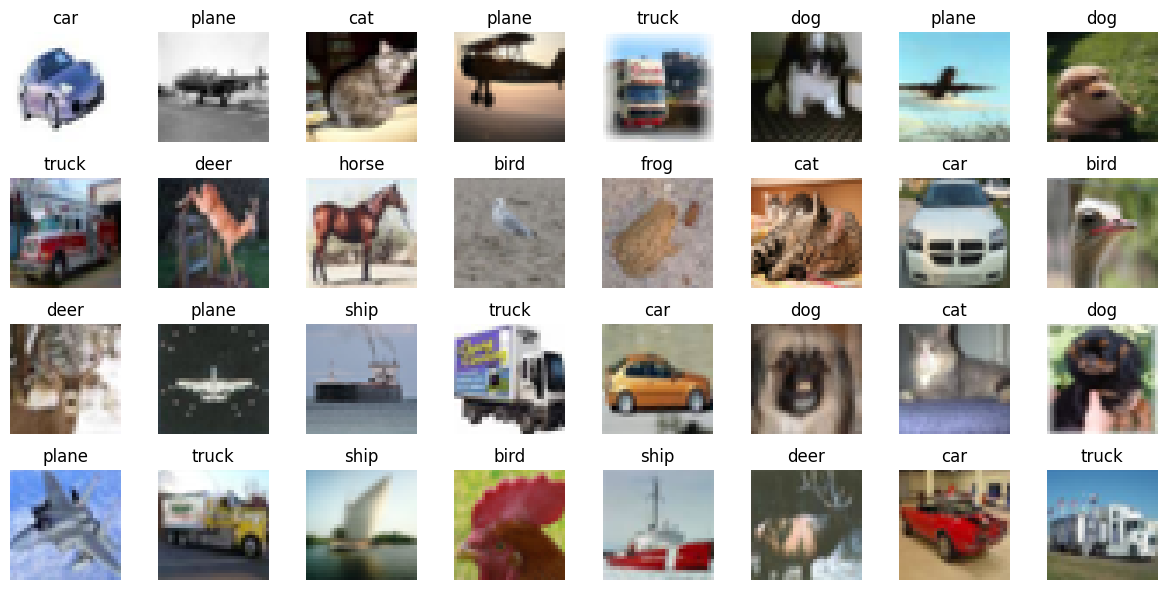

In [ ]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

Final test set performance:
	loss 0.06901053383648395
	accuracy 0.575


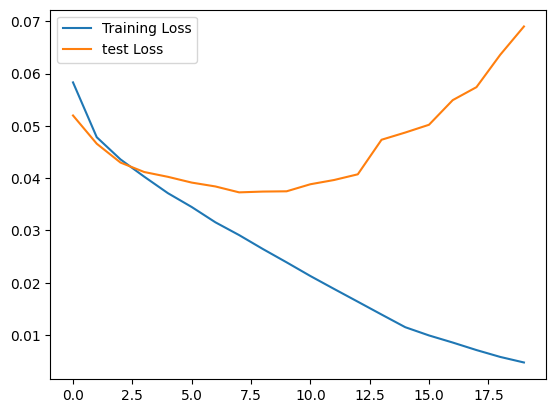

In [ ]:
from torchmetrics.functional import r2_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # Adjust the input size based on the convolutional layers
        self.fc2 = nn.Linear(128, 10)  # Output has 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)  # Adjust the input size based on the convolutional layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    each_node_train_loss = []
    each_node_valid_loss = []
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        lo = []
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        each_node_train_loss.append(epoch_loss.detach().numpy())
        #lo.append(epoch_loss)
        epoch_acc = correct / total
        # plt.plot(epoch_loss)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


        # # Validation loop
        # net.eval()  # Set the model to evaluation mode
        # total_val_loss = 0.0

        # with torch.no_grad():
        #     for inputs, labels in valloaders[0]:
        #         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        #         # Forward pass
        #         outputs = net(inputs)
        #         loss = criterion(outputs, labels)

        #         total_val_loss += loss.item()

        # avg_val_loss = total_val_loss / len(testloader.dataset)
        # each_node_valid_loss.append(avg_val_loss)




    return each_node_train_loss #, each_node_valid_loss


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss, r2loss = 0, 0, 0.0 , 0
    loss_list = []

    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs )
            loss += criterion(outputs, labels).item()
            # r2loss += r2_score(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total

    return loss, accuracy




trainloader = trainloaders[0]
valloader = valloaders[0]

net = Net().to(DEVICE)
test_loss = []
node_loss = []
node_valid_loss = []
for epoch in range(20):
    node_tain = train(net, trainloader, 1, verbose=False)
    node_loss.append(node_tain)
    # node_valid_loss.append(node_valid)
    loss, accuracy = test(net, testloader)
    test_loss.append(loss)

    # print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

train_loss = [tensor.item() for sublist in node_loss for tensor in sublist]

plt.plot(train_loss, label='Training Loss')
# plt.plot(node_valid_loss, label='Valid Loss')

plt.plot(test_loss, label='test Loss')
plt.legend()
plt.show()






In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



In [ ]:
from scipy.integrate import quad

""" Nash Equilibrium Values Calculation """
# write the function values for each of it
n= 5
# node_cost = 0.4
highest_value = 2

def integ(total_resource_cost, score):
    def NE(x):
        # return total_resource_cost * ((1 - np.exp(-score)) / (1 - np.exp(-highest_value)))**(n-3)
        return total_resource_cost * (score / highest_value)**(n-2)


    integral, _ = quad(NE, 0, highest_value)
    print("The Integral Value is = ", integral)

    return integral



""" NE END """


def normalize(data, data_min, data_max):
    d = (data - data_min) / (data_max - data_min)
    return d


""" Functions"""

class Euler():
  def __init__(self, X_init =1, Y_init=1 , step =10 ):
    self.x = np.zeros(step+1)
    self.y = np.zeros(step+1)

    self.x[0] = X_init
    self.y[0] = Y_init
    self.step = step


  def function(self,y,x):
    return y

  def approximate_value(self, x_required):
    h = (x_required - self.x[0]) / self.step

    for k in range(self.step):
      self.x[k+1] = self.x[k] + h
      self.y[k+1] = self.y[k] + h * self.function(self.y[k], self.x[k])
    return self.y[-1]


# Nash Equilibrium
def nash_equilibrium():
  # For each node, calculate q(θ) and p(θ)
  pass



def calculate_p(q):
  resource_value = sum(alpha * q)
  total_resource_cost = sum(resource_cost * q)
  profit = resource_value - total_resource_cost
  euler = Euler()
  p = euler.approximate_value(profit)

  # Have to modify accordingly

  resource_value = sum(alpha * q) + p
  total_resource_cost = sum(resource_cost * q)


  return round(p,2), total_resource_cost


def scoring_function(q,p):
  return np.sum(alpha*q) + p #np.min(alpha * q) +p

In [ ]:
from typing import Dict, Tuple

from flwr.common import Config, NDArrays, Scalar
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetPropertiesIns,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    Config
)


In [ ]:
random.seed(42)

P_MIN = 0.021334328158479184
P_MAX = 0.03875953108451435

DATA_MIN = int(1000)
DATA_MAX = int(5000)

BANDWIDTH_MIN = int(5)
BANDWIDTH_MAX = int(100)

RESOURCE = np.array([[random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX), random.randint(DATA_MIN,DATA_MAX)]], dtype=float) # Bandwidth , Data

alpha = [0.5,0.5] # Alpha value for each feature,
resource_cost = [0.6 , 0.4] # cost for each resource
K= 2


In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

total_loss= []

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.total_loss=list()

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        self.total_loss.append(loss)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    def get_value(self):
      print("value is ", self.total_loss)


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)


    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    cl = FlowerClient(net, trainloader, valloader)
    cl.get_value()

    return cl


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=3,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function

)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


NUM_CLIENTS = 5
num_rounds = 4
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-19 18:14:41,745 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-19 18:14:44,722	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 18:14:47,028 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7856327886.0, 'object_store_memory': 3928163942.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7856327886.0, 'object_store_memory': 3928163942.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-09-19 18:14:47,037 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 18:14:47,046 | app.py:224 | Flower VCE: Resourc

(DefaultActor pid=4684) value is  []
(DefaultActor pid=4684) value is  []
(DefaultActor pid=4683) value is  []
(DefaultActor pid=4684) value is  []
(DefaultActor pid=4683) value is  []
(DefaultActor pid=4684) value is  []


DEBUG flwr 2023-09-19 18:15:57,378 | server.py:236 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-19 18:15:57,405 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 18:15:57,409 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 5)


(DefaultActor pid=4684) value is  []


DEBUG flwr 2023-09-19 18:16:06,712 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-09-19 18:16:06,718 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=4683) value is  []
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:16:54,479 | server.py:236 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:16:54,510 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 5)


(DefaultActor pid=4684) value is  []
(DefaultActor pid=4683) value is  []


DEBUG flwr 2023-09-19 18:17:03,295 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-19 18:17:03,297 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:17:51,967 | server.py:236 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:17:51,989 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 5)


(DefaultActor pid=4684) value is  []
(DefaultActor pid=4683) value is  []


DEBUG flwr 2023-09-19 18:17:59,445 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-19 18:17:59,451 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]
(DefaultActor pid=4684) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:18:46,969 | server.py:236 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:18:46,988 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 5)


(DefaultActor pid=4684) value is  []
(DefaultActor pid=4683) value is  []


DEBUG flwr 2023-09-19 18:18:57,116 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
INFO flwr 2023-09-19 18:18:57,120 | server.py:153 | FL finished in 237.15478551499996
INFO:flwr:FL finished in 237.15478551499996
INFO flwr 2023-09-19 18:18:57,126 | app.py:225 | app_fit: losses_distributed [(1, 0.054003104329109194), (2, 0.0438861587146918), (3, 0.04013842078049978), (4, 0.03748612501223882)]
INFO:flwr:app_fit: losses_distributed [(1, 0.054003104329109194), (2, 0.0438861587146918), (3, 0.04013842078049978), (4, 0.03748612501223882)]
INFO flwr 2023-09-19 18:18:57,129 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-19 18:18:57,131 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.38333333333333336), (2, 0.4933333333333334), (3, 0.5445), (4, 0.5748333333333334)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.3833333

History (loss, distributed):
	round 1: 0.054003104329109194
	round 2: 0.0438861587146918
	round 3: 0.04013842078049978
	round 4: 0.03748612501223882
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.38333333333333336), (2, 0.4933333333333334), (3, 0.5445), (4, 0.5748333333333334)]}

In [ ]:

class FlowerClient(fl.client.NumPyClient):

    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.payment = list()
        self.node_train_loss = list()
        self.node_valid_loss = list()
        self.server_round =1
        self.RESOURCE = np.array([[self.cid,normalize(random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX),BANDWIDTH_MIN,BANDWIDTH_MAX), normalize(random.randint(DATA_MIN,DATA_MAX),DATA_MIN,DATA_MAX)]] , dtype=float) # ID,Bandwidth , Data



    # return res. as dictionary here
    def get_properties(self, config: Config) -> Dict[str, Scalar]:
        retDict = {"client_id": self.cid,"bandwidth" : self.RESOURCE[0][1], "data" : self.RESOURCE[0][2]}
        return retDict



    # Return the current local model parameters
    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)



    # Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
    def fit(self, parameters, config):

        # Read values from config
        server_round = 1 #config["server_round"]
        local_epochs = 5 #config["local_epochs"]

        score = config["bid_score"]


        if "train" in config:
          print(str(self.cid) + " -> Please try train")
          self.payment.append(config["payment"])
          print("Payment Received",self.payment)


          # Use values provided by the config
          print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")

          set_parameters(self.net, parameters)
          node_loss = train(self.net, self.trainloader, epochs=local_epochs)

          values_train_loss = [arr.item() for arr in node_loss]

          print("Values of each node loss",values_train_loss)
          self.node_train_loss.append(values_train_loss)
          plt.plot(self.node_train_loss[0], label="Training Loss" )
          plt.title(f'Node {self.cid}')
          plt.xticks(np.arange(local_epochs))
          plt.savefig(f"CIFAR10_Node_{self.cid}.png")
          plt.show()


        else:

          print("skip training")

        results = dict()
        results["node_train_loss"] = self.node_train_loss[0]



        return get_parameters(self.net), len(self.trainloader), {}



    # : Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server
    def evaluate(self, parameters, config):

        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


    def get_node_losses(self):

      return self.node_train_loss




def fit_config(server_round: int):
    """Return training configuration dict for each round.
    """

    config = {

        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config




def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    cl = FlowerClient(cid, net, trainloader, valloader)

    return cl



class MyStrategy(fl.server.strategy.FedAvg):
    #def initialize_parameters(self, client_manager):
        # Your implementation here

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        all_connected_clients_dict = client_manager.all()
        all_client_properties = list()

        for dict_key in all_connected_clients_dict.keys():
          config = {}
          ins = GetPropertiesIns(config=config)
          res = all_connected_clients_dict[dict_key].get_properties(ins, 100)
          res = (res.properties)
          all_client_properties.append(res)

        # preprocess to calculte bid Score  and p_value

        client_id = [[client_id["client_id"]] for client_id in  all_client_properties]
        bandwidth_data = [[d["bandwidth"],d["data"]] for d in all_client_properties]
        bandwidth_data = np.asarray(bandwidth_data)
        print("bandwidth_data",bandwidth_data)


        """
        # NE to calculate Payment Allocation

        """
        scoring_board = list()
        p_client = list()
        payment = list()
        for q in bandwidth_data:

          p_value, total_resource_cost = calculate_p(q)
          p_client.append(p_value)

          client_bid_socre = scoring_function(q,p_value)

          """ NE """
          node_payment = client_bid_socre  + integ(total_resource_cost,client_bid_socre)

          """ NE """

          scoring_board.append(client_bid_socre)
          payment.append(node_payment*100)
          print(client_bid_socre, node_payment)


        score_dic = [{"client_id":id , "bid_score" : score , "p_value" : p , "payment" : node_payment } for id, score , p ,node_payment  in zip(client_id,scoring_board, p_client,payment)]
        print("Client Scoring Board",score_dic)

        top_k = sorted(score_dic, key=lambda x:x["bid_score"], reverse =True)
        top_k = top_k[:K]
        print("The Client with Higher Score", top_k)


        # Selecting the Top k for Training
        client_to_train = list()
        top_client_ids = [[client_id["client_id"]] for client_id in  top_k]


        # chosing client for training
        for client in top_k:


          client_id = client["client_id"]
          payment = client["payment"]
          score = client["bid_score"]

          proxy = all_connected_clients_dict[str(client_id[0][0])]
          # print("proxy", proxy)

          # Create a dict to send instruction
          dic = {"train" : True,"bid_score" :score ,"payment" : payment}

          fitIn = FitIns(parameters=parameters, config=dic)
          client_to_train.append([proxy, fitIn])

        print("Returing to CLient to Train")
        return client_to_train



    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
          # Convert `Parameters` to `List[np.ndarray]`
          aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

          # Save aggregated_ndarrays
          print(f"Saving round {server_round} aggregated_ndarrays...")
          np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

        print("Server round -> " + str(server_round))
        # for result in results:
        #   print("Here is the result", str(result.FitRes))

        return aggregated_parameters, aggregated_metrics


    #def configure_evaluate(self, server_round, parameters, client_manager):
        # Your implementation here

    # def aggregate_evaluate(self, server_round, results, failures):
        # Your implementation here

    #def evaluate(self, parameters):
        # Your implementation here
NUM_CLIENTS = 5
NUM_ROUND = 4



def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}



strategy = MyStrategy(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function

    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    # evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)




client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-09-19 18:18:57,221 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-19 18:19:01,509	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 18:19:03,784 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3923462553.0, 'CPU': 2.0, 'memory': 7846925108.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3923462553.0, 'CPU': 2.0, 'memory': 7846925108.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-19 18:19:03,790 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 18:19:03,797 | app.py:224 | Flower VCE: Resourc

bandwidth_data [[0.14736842 0.476     ]
 [0.36842105 0.74125   ]
 [0.53684211 0.32275   ]
 [0.89473684 0.89925   ]
 [0.75789474 0.40725   ]]
The Integral Value is =  0.02112326216215163
0.6716842105263158 0.6928074726884674
The Integral Value is =  0.09906576423622027
0.9148355263157895 1.0139012905520097
The Integral Value is =  0.05145661399979228
0.769796052631579 0.8212526666313713
The Integral Value is =  0.43461347361929126
1.2469934210526317 1.681606894671923
The Integral Value is =  0.12124798553132934
0.9225723684210527 1.043820353952382
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.6716842105263158, 'p_value': 0.36, 'payment': 69.28074726884674}, {'client_id': ['1'], 'bid_score': 0.9148355263157895, 'p_value': 0.36, 'payment': 101.39012905520097}, {'client_id': ['2'], 'bid_score': 0.769796052631579, 'p_value': 0.34, 'payment': 82.12526666313713}, {'client_id': ['3'], 'bid_score': 1.2469934210526317, 'p_value': 0.35, 'payment': 168.1606894671923}, {'client_id': ['4

DEBUG flwr 2023-09-19 18:20:48,853 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-19 18:20:48,867 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 18:20:48,879 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)


Saving round 1 aggregated_ndarrays...
Server round -> 1
(DefaultActor pid=5994) [Client 3] evaluate, config: {}
(DefaultActor pid=5994) Values of each node loss [0.05944588780403137, 0.04768264293670654, 0.04240492731332779, 0.03811242803931236, 0.034673675894737244]
(DefaultActor pid=5994) Figure(640x480)
(DefaultActor pid=5994) [Client 2] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:21:07,958 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:21:18,616 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.33684211 0.024     ]
 [0.24210526 0.725     ]
 [0.25263158 0.56425   ]
 [0.50526316 0.72325   ]
 [0.64210526 0.159     ]]
The Integral Value is =  0.007459955453045968
0.520421052631579 0.527881008084625
The Integral Value is =  0.06766792109470947
0.8535526315789473 0.9212205526736568
The Integral Value is =  0.04279901843742399
0.7684407894736842 0.8112398079111082
The Integral Value is =  0.13696750388452117
0.9742565789473684 1.1112240828318896
The Integral Value is =  0.04375306660995533
0.7305526315789475 0.7743056981889028
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.520421052631579, 'p_value': 0.34, 'payment': 52.7881008084625}, {'client_id': ['1'], 'bid_score': 0.8535526315789473, 'p_value': 0.37, 'payment': 92.12205526736568}, {'client_id': ['2'], 'bid_score': 0.7684407894736842, 'p_value': 0.36, 'payment': 81.12398079111081}, {'client_id': ['3'], 'bid_score': 0.9742565789473684, 'p_value': 0.36, 'payment': 111.12240828318896}, {'client_id': ['

DEBUG flwr 2023-09-19 18:22:43,321 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-19 18:22:43,339 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)


Saving round 2 aggregated_ndarrays...
Server round -> 2
(DefaultActor pid=5996) [Client 4] evaluate, config: {}
(DefaultActor pid=5996) Values of each node loss [0.038685742765665054, 0.034478072077035904, 0.030633512884378433, 0.02708628959953785, 0.023814288899302483]
(DefaultActor pid=5996) Figure(640x480)
(DefaultActor pid=5996) [Client 2] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:22:57,953 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:23:06,435 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.44210526 0.15175   ]
 [0.66315789 0.2055    ]
 [0.09473684 0.27375   ]
 [0.74736842 0.26275   ]
 [0.47368421 0.251     ]]
The Integral Value is =  0.021056141748292272
0.6369276315789474 0.6579837733272397
The Integral Value is =  0.053592976413958236
0.764328947368421 0.8179219237823793
The Integral Value is =  0.006703811066045605
0.5442434210526316 0.5509472321186771
The Integral Value is =  0.08057975894563042
0.8350592105263157 0.9156389694719461
The Integral Value is =  0.033312504882475676
0.702342105263158 0.7356546101456337
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.6369276315789474, 'p_value': 0.34, 'payment': 65.79837733272397}, {'client_id': ['1'], 'bid_score': 0.764328947368421, 'p_value': 0.33, 'payment': 81.79219237823793}, {'client_id': ['2'], 'bid_score': 0.5442434210526316, 'p_value': 0.36, 'payment': 55.094723211867716}, {'client_id': ['3'], 'bid_score': 0.8350592105263157, 'p_value': 0.33, 'payment': 91.5638969471946}, {'client_id':

DEBUG flwr 2023-09-19 18:24:29,647 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-19 18:24:29,667 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)


Saving round 3 aggregated_ndarrays...
Server round -> 3
(DefaultActor pid=5994) [Client 2] evaluate, config: {}
(DefaultActor pid=5994) Values of each node loss [0.026677407324314117, 0.022100821137428284, 0.018581269308924675, 0.015578334219753742, 0.012457969598472118]
(DefaultActor pid=5994) Figure(640x480)
(DefaultActor pid=5994) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=5994) [Client 4] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:24:45,130 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-19 18:24:52,929 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.49473684 0.6025    ]
 [0.24210526 0.69225   ]
 [0.50526316 0.973     ]
 [0.32631579 0.7445    ]
 [0.23157895 0.222     ]]
The Integral Value is =  0.09757100045976917
0.8986184210526316 0.9961894215124008
The Integral Value is =  0.06192602252641477
0.8371776315789474 0.8991036541053622
The Integral Value is =  0.23616735691171886
1.1091315789473684 1.3452989358590872
The Integral Value is =  0.0915880323942019
0.9054078947368421 0.996995927131044
The Integral Value is =  0.010925601451283079
0.5767894736842105 0.5877150751354936
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.8986184210526316, 'p_value': 0.35, 'payment': 99.61894215124008}, {'client_id': ['1'], 'bid_score': 0.8371776315789474, 'p_value': 0.37, 'payment': 89.91036541053622}, {'client_id': ['2'], 'bid_score': 1.1091315789473684, 'p_value': 0.37, 'payment': 134.52989358590872}, {'client_id': ['3'], 'bid_score': 0.9054078947368421, 'p_value': 0.37, 'payment': 99.69959271310441}, {'client_id': 

DEBUG flwr 2023-09-19 18:26:17,916 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-19 18:26:17,944 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


Saving round 4 aggregated_ndarrays...
Server round -> 4
(DefaultActor pid=5996) [Client 3] evaluate, config: {}
(DefaultActor pid=5996) Values of each node loss [0.01722635328769684, 0.011271127499639988, 0.008472445420920849, 0.006345160771161318, 0.00480065168812871]
(DefaultActor pid=5996) Figure(640x480)
(DefaultActor pid=5996) [Client 2] evaluate, config: {} [repeated 2x across cluster]


DEBUG flwr 2023-09-19 18:26:35,642 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
INFO flwr 2023-09-19 18:26:35,649 | server.py:153 | FL finished in 451.77854184600005
INFO:flwr:FL finished in 451.77854184600005
INFO flwr 2023-09-19 18:26:35,653 | app.py:225 | app_fit: losses_distributed [(1, 0.043944715422391895), (2, 0.03235794512629509), (3, 0.034940304052829746), (4, 0.03648036678433418)]
INFO:flwr:app_fit: losses_distributed [(1, 0.043944715422391895), (2, 0.03235794512629509), (3, 0.034940304052829746), (4, 0.03648036678433418)]
INFO flwr 2023-09-19 18:26:35,656 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-19 18:26:35,658 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.5238), (2, 0.6429999999999999), (3, 0.6635), (4, 0.6733999999999999)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.5238), (2, 0.642

History (loss, distributed):
	round 1: 0.043944715422391895
	round 2: 0.03235794512629509
	round 3: 0.034940304052829746
	round 4: 0.03648036678433418
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.5238), (2, 0.6429999999999999), (3, 0.6635), (4, 0.6733999999999999)]}